In [1]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Data loading 

We will use the cleaned datsets from the `generateDefinitiveDataset.ipynb` notebook that are: 
- **Consumption data**: Split parquet files in `clean/split_consum_bcn/`
- **Leak incidents data**: Single parquet file `clean/fuites_clean_bcn.parquet`
- **Weather data**: `clean/weather_clean.parquet`
- **Socioeconomic data**: `clean/socio_clean.parquet`

In [2]:
# Weather
df_weather = pd.read_parquet("clean/weather_clean.parquet")
# Socioeconomic
df_socio = pd.read_parquet("clean/socio_clean.parquet")
# Leaks
df_fuites = pd.read_parquet("clean/fuites_clean_bcn.parquet")
# Consumption split files
consum_files = sorted(glob.glob("clean/split_consum_bcn/consum_clean_bcn_part_*.parquet"))
df_consum_list = [pd.read_parquet(fp) for fp in consum_files]
df_consum = pd.concat(df_consum_list, ignore_index=True)

print("\nLoaded datasets:")
print(f"  Weather: {df_weather.shape[0]:,} rows")
print(f"  Socioeconomic: {df_socio.shape[0]:,} rows")
print(f"  Leaks: {df_fuites.shape[0]:,} rows")
print(f"  Consumption: {df_consum.shape[0]:,} rows from {len(consum_files)} split files")


Loaded datasets:
  Weather: 129,104 rows
  Socioeconomic: 1,068 rows
  Leaks: 1,359 rows
  Consumption: 10,068,280 rows from 18 split files


# 1. Data Validation

## 1.1 General Validation

- This script checks the datatypes of the fields of each dataset, validates the spacio-temporal coverage and checks for duplicate rows. 
- Specific to the weather dataset, it checks that no out of range values appear, according to `Unitat`

In [3]:
print("="*120)
print("DATA VALIDATION REPORT")
print("="*120)

# ==========================================================================================
# 1. VALIDATE COLUMN TYPES + NULLS
# ==========================================================================================

def validate_dataset(df, name):
    print("\n" + "-"*80)
    print(f"VALIDATION: {name}")
    print("-"*80)
    
    # Check column types
    print("\nColumn types:")
    print(df.dtypes)
    
    # Missing values
    print("\nMissing values (top 10):")
    print(df.isna().sum().sort_values(ascending=False).head(10))
    
    # Duplicate rows
    dup_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup_count:,}")
    
    # Memory usage
    print(f"Memory usage: {df.memory_usage(deep=True).sum()/1024/1024:.2f} MB")

validate_dataset(df_consum, "Consumption")
validate_dataset(df_fuites, "Leaks")
validate_dataset(df_weather, "Weather")
validate_dataset(df_socio, "Socioeconomic")

# ==========================================================================================
# 2. VALIDATE TEMPORAL COVERAGE
# ==========================================================================================

def validate_dates(df, date_col, name):
    print("\n" + "-"*80)
    print(f"TEMPORAL VALIDATION: {name}")
    print("-"*80)

    if date_col not in df.columns:
        print(f"⚠ Date column '{date_col}' missing!")
        return
    
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    n_null = df[date_col].isna().sum()

    print(f"Null dates: {n_null:,}")
    print(f"Earliest date: {df[date_col].min()}")
    print(f"Latest date: {df[date_col].max()}")
    print(f"Unique dates: {df[date_col].nunique():,}")

validate_dates(df_consum, "FECHA", "Consumption")
validate_dates(df_fuites, "CREATED_MENSAJE", "Leaks")
validate_dates(df_weather, "DATA_LECTURA", "Weather")

# ==========================================================================================
# 3. VALIDATE SPATIAL COVERAGE (SECCIO_CENSAL)
# ==========================================================================================

def validate_spatial(df, name):
    print("\n" + "-"*80)
    print(f"SPATIAL VALIDATION: {name}")
    print("-"*80)

    if "SECCIO_CENSAL" not in df.columns:
        print("⚠ Missing SECCIO_CENSAL column")
        return

    unique_sections = df["SECCIO_CENSAL"].nunique()
    print(f"Unique SECCIO_CENSAL count: {unique_sections:,}")

    # Check formatting: all codes should be 11 digits starting with 080193
    mask_valid = df["SECCIO_CENSAL"].astype(str).str.match(r"^080193\d{5}$")
    invalid = df.loc[~mask_valid, "SECCIO_CENSAL"]

    print(f"Invalid census codes: {len(invalid)}")
    if len(invalid) > 0:
        print(invalid.head())

validate_spatial(df_consum, "Consumption")
validate_spatial(df_fuites, "Leaks")
validate_spatial(df_socio, "Socioeconomic")

# ==========================================================================================
# 4. CROSS-DATASET ALIGNMENT CHECKS
# ==========================================================================================

print("\n" + "="*120)
print("CROSS-DATASET ALIGNMENT")
print("="*120)

# Unique census sections
sec_consum = set(df_consum["SECCIO_CENSAL"].unique())
sec_fuites = set(df_fuites["SECCIO_CENSAL"].unique())
sec_socio  = set(df_socio["SECCIO_CENSAL"].unique())

print(f"\nTotal census sections:")
print(f"  Socioeconomic: {len(sec_socio):,}")
print(f"  Consumption:  {len(sec_consum):,}")
print(f"  Leaks:        {len(sec_fuites):,}")

# Intersections
print("\nIntersections:")
print(f"  Socio ∩ Consum: {len(sec_socio & sec_consum):,}")
print(f"  Socio ∩ Fuites: {len(sec_socio & sec_fuites):,}")
print(f"  Consum ∩ Fuites: {len(sec_consum & sec_fuites):,}")
print(f"  All three: {len(sec_socio & sec_consum & sec_fuites):,}")

# ==========================================================================================
# 5. CHECK FOR DUPLICATE METERS IN CONSUMPTION
# ==========================================================================================

print("\n" + "="*120)
print("METER VALIDATION (Consumption)")
print("="*120)

# A meter should not have overlapping dates
df_consum["FECHA"] = pd.to_datetime(df_consum["FECHA"], errors="coerce")
dup_meter_date = df_consum.duplicated(subset=["POLIZA_SUMINISTRO", "FECHA"]).sum()

print(f"Duplicate (POLIZA_SUMINISTRO + FECHA) rows: {dup_meter_date:,}")

# ==========================================================================================
# 6. VALUE VALIDATION — UNIT-AWARE WEATHER CHECKS
# ==========================================================================================

print("\n" + "="*120)
print("VALUE VALIDATION (Unit-aware)")
print("="*120)

print("\nUnique UNITAT values in df_weather:")
print(df_weather["UNITAT"].unique())

rules = {
    "°C": (-40, 50),        # realistic temperature range for Barcelona
    "%": (0, 100),          # valid humidity range
    "hPa": (900, 1100),     # typical pressure range
    "mm": (0, 500),         # rainfall per day upper cap (rare but possible)
    "MJ/m2": (0, 40),       # solar radiation
    "m/s": (0, 40),         # wind speed
    "°": (0, 360)           # direction angles
}

invalid_summary = []

for unit, (lo, hi) in rules.items():
    mask = df_weather["UNITAT"] == unit
    subset = df_weather[mask]

    invalid = subset[(subset["VALOR_NUM"] < lo) | (subset["VALOR_NUM"] > hi)]
    invalid_summary.append((unit, len(invalid)))

    print(f"\nUNIT: {unit}")
    print(f"  Allowed range: {lo} to {hi}")
    print(f"  Rows checked: {len(subset):,}")
    print(f"  Invalid values: {len(invalid):,}")

print("\nSummary of invalid per unit:")
for u, cnt in invalid_summary:
    print(f"  {u}: {cnt} invalid values")


print("\nDATA VALIDATION COMPLETED.")


DATA VALIDATION REPORT

--------------------------------------------------------------------------------
VALIDATION: Consumption
--------------------------------------------------------------------------------

Column types:
POLIZA_SUMINISTRO            object
FECHA                datetime64[ns]
CONSUMO_REAL                  int64
SECCIO_CENSAL                object
US_AIGUA_GEST                object
DATA_INST_COMP       datetime64[ns]
dtype: object

Missing values (top 10):
POLIZA_SUMINISTRO    0
FECHA                0
CONSUMO_REAL         0
SECCIO_CENSAL        0
US_AIGUA_GEST        0
DATA_INST_COMP       0
dtype: int64

Duplicate rows: 0
Memory usage: 2141.21 MB

--------------------------------------------------------------------------------
VALIDATION: Leaks
--------------------------------------------------------------------------------

Column types:
POLISSA_SUBM       object
CREATED_MENSAJE    object
CODIGO_MENSAJE     object
US_AIGUA_SUBM      object
SECCIO_CENSAL      objec

In order to finish the data validation and fix the problems encountered we will: 
- Drop the 103 duplicate rows of the **consum dataset** in order to have only unique entries. Each pair of duplicates is in the same chunk so we will clean all the chunks in order to have only unique values. 
- Drop the 197 missing entries for Estat in the **weather dataset** since we only want the representative values, no need to keep the non-representative, and since the entire column will have the same value, we can drop the entire column once the missing values have been removed. 


In [4]:
# Folder with split consumption files
consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))

print(f"Found {len(consum_files)} split consum files")
print("-" * 80)

key_cols = ['POLIZA_SUMINISTRO', 'FECHA']

total_before = 0
total_after = 0
total_dups_removed = 0

# -------------------------------------------------------------------
# 1. Deduplicate *within each chunk* and overwrite file
# -------------------------------------------------------------------
for i, fp in enumerate(consum_files, start=1):
    file_name = Path(fp).name
    print(f"Processing chunk {i}/{len(consum_files)}: {file_name}")

    df_chunk = pd.read_parquet(fp)
    total_before += len(df_chunk)

    # Ensure FECHA is datetime
    df_chunk['FECHA'] = pd.to_datetime(df_chunk['FECHA'], errors='coerce')

    # Detect duplicate rows within the chunk
    dup_mask = df_chunk.duplicated(subset=key_cols, keep='first')
    n_dups = dup_mask.sum()
    total_dups_removed += n_dups

    if n_dups > 0:
        print(f"  - Found {n_dups} duplicates inside chunk")

    # Drop duplicates (keep first)
    df_clean = df_chunk.drop_duplicates(subset=key_cols, keep='first')
    total_after += len(df_clean)

    # Overwrite chunk file IN PLACE
    df_clean.to_parquet(fp, index=False)
    print(f"  - Saved cleaned chunk ({len(df_clean)} rows)")

print("-" * 80)
print(f"Total rows before cleaning: {total_before:,}")
print(f"Total rows after cleaning:  {total_after:,}")
print(f"Total duplicates removed:   {total_dups_removed:,}")

# -------------------------------------------------------------------
# 2. Global duplicate check (across chunks)
# -------------------------------------------------------------------
print("\nChecking for duplicates across chunks...")

df_all = []
for fp in consum_files:
    df_chunk = pd.read_parquet(fp)
    df_all.append(df_chunk)

df_all = pd.concat(df_all, ignore_index=True)

global_dups = df_all.duplicated(subset=key_cols, keep=False).sum()

if global_dups == 0:
    print("✓ No global duplicates remain across chunks!")
else:
    print(f"⚠ Found {global_dups} duplicates across chunks (should be 0).")

# -------------------------------------------------------------------
# 3. Drop missing Estat in weather data + drop Estat column
# -------------------------------------------------------------------
# Consumption split files
consum_files = sorted(glob.glob("clean/split_consum_bcn/consum_clean_bcn_part_*.parquet"))
df_consum_list = [pd.read_parquet(fp) for fp in consum_files]
df_consum = pd.concat(df_consum_list, ignore_index=True)


# 1. Drop rows where Estat is NaN (they are invalid / not useful)
df_weather = df_weather[df_weather['Estat'].notna()].copy()

# 2. Drop Estat column entirely because it holds no useful information
df_weather = df_weather.drop(columns=['Estat'])

print("After cleaning:", df_weather.shape)
print("Columns now:", df_weather.columns)

# Save cleaned version (overwrite or create a new name)
output = Path("clean/weather_clean.parquet")
df_weather.to_parquet(output, index=False)

print("\n✓ Cleaned weather data saved to:", output)

Found 18 split consum files
--------------------------------------------------------------------------------
Processing chunk 1/18: consum_clean_bcn_part_001.parquet
  - Saved cleaned chunk (24725 rows)
Processing chunk 2/18: consum_clean_bcn_part_002.parquet
  - Saved cleaned chunk (142432 rows)
Processing chunk 3/18: consum_clean_bcn_part_003.parquet
  - Saved cleaned chunk (127911 rows)
Processing chunk 4/18: consum_clean_bcn_part_004.parquet
  - Saved cleaned chunk (68311 rows)
Processing chunk 5/18: consum_clean_bcn_part_005.parquet
  - Saved cleaned chunk (391381 rows)
Processing chunk 6/18: consum_clean_bcn_part_006.parquet
  - Saved cleaned chunk (999987 rows)
Processing chunk 7/18: consum_clean_bcn_part_007.parquet
  - Saved cleaned chunk (903217 rows)
Processing chunk 8/18: consum_clean_bcn_part_008.parquet
  - Saved cleaned chunk (776714 rows)
Processing chunk 9/18: consum_clean_bcn_part_009.parquet
  - Saved cleaned chunk (735314 rows)
Processing chunk 10/18: consum_clean_b

KeyError: 'Estat'

## 1.2 Validation part 2

From this validation we get some important information: 
- in the **consum** dataset there are 3 missing days of data which may explain some gap we could potentially see in a time series visualization or correlation analysis with weather
- in the **weather** dataset there are 2 missing days of data

In [5]:
print("="*120)
print("PART 2 — EXTENDED VALIDATION")
print("="*120)

# ============================================================
# A) TEMPORAL OVERLAP + MISSING DAYS CHECK
# ============================================================

def check_missing_days(df, date_col, name):
    print("\n" + "-"*80)
    print(f"MISSING-DAY VALIDATION: {name}")
    print("-"*80)

    df = df.copy()
    dates = df[date_col].dropna().sort_values()

    if dates.empty:
        print("⚠ No valid dates found.")
        return

    full_range = pd.date_range(start=dates.min(), end=dates.max(), freq="D")
    missing_days = full_range.difference(dates.unique())

    print(f"Date range: {dates.min().date()} → {dates.max().date()}")
    print(f"Total days expected: {len(full_range):,}")
    print(f"Actual days present: {dates.nunique():,}")
    print(f"Missing days: {len(missing_days):,}")

    if len(missing_days) > 0:
        print("\nFirst 20 missing days:")
        print(missing_days[:20])

check_missing_days(df_consum, "FECHA", "Consumption")
check_missing_days(df_fuites, "CREATED_MENSAJE", "Leaks")
check_missing_days(df_weather, "DATA_LECTURA", "Weather")


# ============================================================
# C) OUTLIER DETECTION (Consumption + Leaks)
# ============================================================

print("\n" + "="*120)
print("OUTLIER VALIDATION")
print("="*120)

# ---------- Consumption outliers ----------
print("\nConsumption outlier analysis:")
q1 = df_consum["CONSUMO_REAL"].quantile(0.25)
q3 = df_consum["CONSUMO_REAL"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 3 * iqr   # conservative
lower_bound = q1 - 1.5 * iqr

outliers_high = df_consum[df_consum["CONSUMO_REAL"] > upper_bound]
outliers_low = df_consum[df_consum["CONSUMO_REAL"] < lower_bound]

print(f"Total consumption rows: {len(df_consum):,}")
print(f"High outliers (> {upper_bound:.1f}): {len(outliers_high):,}")
print(f"Low outliers (< {lower_bound:.1f}): {len(outliers_low):,}")

# Leak outliers = unusually high leak counts in one day
print("\nLeak frequency outliers:")
daily_leak_counts = df_fuites.groupby("CREATED_MENSAJE").size()
mean_leaks = daily_leak_counts.mean()
std_leaks = daily_leak_counts.std()

high_leak_days = daily_leak_counts[daily_leak_counts > mean_leaks + 3*std_leaks]

print(f"Mean leaks/day: {mean_leaks:.2f}")
print(f"High leak anomaly days (> mean + 3σ): {len(high_leak_days)}")
if len(high_leak_days) > 0:
    print(high_leak_days.head())


# ============================================================
# C) SENSOR / METER STABILITY CHECK
# ============================================================

print("\n" + "="*120)
print("SENSOR / METER STABILITY VALIDATION")
print("="*120)

# Step 1: Count readings per meter
counts_per_meter = df_consum.groupby("POLIZA_SUMINISTRO")["FECHA"].nunique()

print(f"Total meters: {len(counts_per_meter):,}")
print(f"Meters with < 30 days of readings: {(counts_per_meter < 30).sum():,}")
print(f"Meters with < 7 days of readings:  {(counts_per_meter < 7).sum():,}")

print("\nMeters with extremely few readings (first 20):")
print(counts_per_meter[counts_per_meter < 7].head(20))

# Step 2: Check for large gaps in individual meters
print("\nChecking meters with large gaps between readings...")

def meter_gap_analysis(df):
    gaps = []
    for meter, group in df.groupby("POLIZA_SUMINISTRO"):
        dates = group["FECHA"].dropna().sort_values()
        if len(dates) < 2:
            continue
        diffs = dates.diff().dt.days
        max_gap = diffs.max()
        gaps.append(max_gap)
    return gaps

meter_gaps = meter_gap_analysis(df_consum)

print(f"\nMeters analyzed: {len(meter_gaps):,}")
print(f"Average max gap: {np.mean(meter_gaps):.2f} days")
print(f"Meters with gaps > 60 days: {(np.array(meter_gaps) > 60).sum():,}")

print("\nValidation Part 2 Completed.")


PART 2 — EXTENDED VALIDATION

--------------------------------------------------------------------------------
MISSING-DAY VALIDATION: Consumption
--------------------------------------------------------------------------------
Date range: 2021-01-01 → 2024-12-31
Total days expected: 1,461
Actual days present: 1,458
Missing days: 3

First 20 missing days:
DatetimeIndex(['2022-07-08', '2022-07-09', '2022-07-10'], dtype='datetime64[ns]', freq='D')

--------------------------------------------------------------------------------
MISSING-DAY VALIDATION: Leaks
--------------------------------------------------------------------------------
Date range: 2023-01-04 → 2025-05-27
Total days expected: 875
Actual days present: 505
Missing days: 370

First 20 missing days:
DatetimeIndex(['2023-01-05', '2023-01-06', '2023-01-07', '2023-01-10',
               '2023-01-13', '2023-01-14', '2023-01-17', '2023-01-20',
               '2023-01-21', '2023-01-24', '2023-01-29', '2023-01-30',
               '

# 2. Correlation and trend analysis

In [6]:
# ============================================================
# 1. ENSURE DATE COLUMNS ARE IN DATETIME (SAFETY)
# ============================================================
df_consum['FECHA'] = pd.to_datetime(df_consum['FECHA'], errors='coerce')
df_fuites['CREATED_MENSAJE'] = pd.to_datetime(df_fuites['CREATED_MENSAJE'], errors='coerce')
df_weather['DATA_LECTURA'] = pd.to_datetime(df_weather['DATA_LECTURA'], errors='coerce')

# ============================================================
# 2. DAILY AGGREGATES (CITY-LEVEL)
# ============================================================

# 2.1 Daily total consumption (sum over all SECCIO_CENSAL)
daily_consum = (
    df_consum
    .groupby('FECHA')['CONSUMO_REAL']
    .sum()
    .reset_index()
    .rename(columns={'FECHA': 'date', 'CONSUMO_REAL': 'total_consumption'})
)

# 2.2 Daily number of leaks (count of leak events)
daily_leaks = (
    df_fuites
    .groupby('CREATED_MENSAJE')['POLISSA_SUBM']
    .count()
    .reset_index()
    .rename(columns={'CREATED_MENSAJE': 'date', 'POLISSA_SUBM': 'num_leaks'})
)

# 2.3 Daily weather variables (pivot NOM_VARIABLE → columns)
weather_vars = {
    "Temperatura màxima diària + hora": "temp_max",
    "Temperatura mínima diària + hora": "temp_min",
    "Temperatura mitjana diària": "temp_avg",
    "Humitat relativa mitjana diària": "humidity",
    "Precipitació acumulada diària": "rain",
    "Pressió atmosfèrica mitjana diària": "pressure",
    "Irradiació solar global diària": "solar",
    "Velocitat mitjana diària del vent 10 m (esc.)": "wind_speed",
}

weather_sub = df_weather[df_weather["NOM_VARIABLE"].isin(weather_vars.keys())].copy()
weather_sub["variable"] = weather_sub["NOM_VARIABLE"].map(weather_vars)

weather_pivot = (
    weather_sub
    .pivot_table(
        index='DATA_LECTURA',
        columns='variable',
        values='VALOR_NUM',
        aggfunc='mean'
    )
    .reset_index()
    .rename(columns={'DATA_LECTURA': 'date'})
)

## 2.1 Correlation Matrices and Trend analysis

Correlation dataset shape: (1458, 11)
        date  total_consumption  num_leaks  humidity    pressure      rain  \
0 2021-01-01            1767535        0.0     67.50  984.233333  0.433333   
1 2021-01-02            1948941        0.0     61.25  985.000000  0.000000   
2 2021-01-03            1994887        0.0     49.25  988.833333  0.000000   
3 2021-01-04            2190905        0.0     59.25  988.166667  0.000000   
4 2021-01-05            2236425        0.0     65.00  989.366667  0.000000   

      solar  temp_avg  temp_max  temp_min  wind_speed  
0  1.666667     7.650      9.10     5.525    3.300000  
1  7.000000     5.900      9.40     2.850    4.100000  
2  8.566667     5.325      9.80     2.575    3.300000  
3  8.900000     5.600     10.30     2.275    2.466667  
4  7.100000     4.950      9.35     2.075    2.533333  


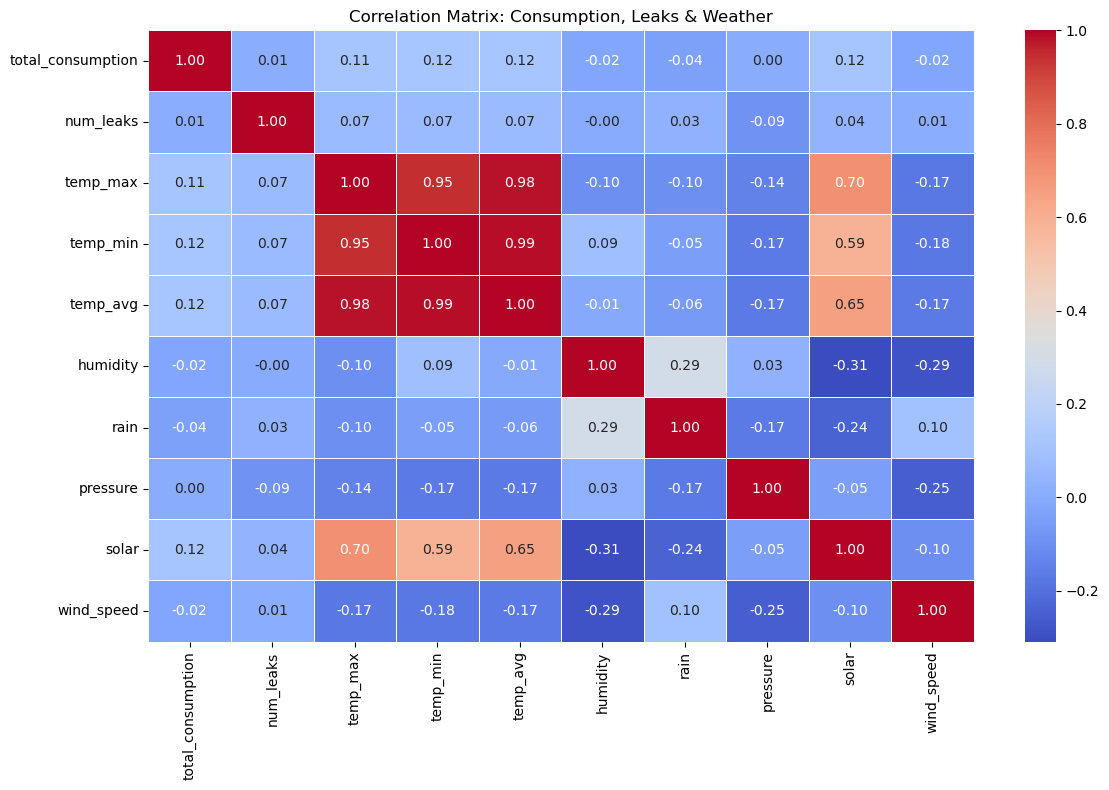

In [7]:
# ============================================================
# 3. BUILD CORRELATION DATAFRAME (NO FULL SPATIAL MERGE)
# ============================================================

df_corr = (
    daily_consum
    .merge(daily_leaks, on='date', how='left')
    .merge(weather_pivot, on='date', how='left')
)

# Missing leaks = 0 leaks that day
df_corr['num_leaks'] = df_corr['num_leaks'].fillna(0)

print("Correlation dataset shape:", df_corr.shape)
print(df_corr.head())

# ============================================================
# 4. CORRELATION MATRIX
# ============================================================

corr_vars = [
    'total_consumption',
    'num_leaks',
    'temp_max', 'temp_min', 'temp_avg',
    'humidity', 'rain', 'pressure',
    'solar', 'wind_speed'
]

corr_df = df_corr[corr_vars]

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Correlation Matrix: Consumption, Leaks & Weather")
plt.tight_layout()
plt.show()


We recompute the same correlation matrix but by season/stratified correlations:
- **hot days vs. cold days**: defined by `temp_avg` quartiles: 
    - bottom **25%** corresponds to cold days 
    - middle **50%** corresponds to mild days 
    - top **25%** corresponds to hot days
- **weekdays vs. weekend**: defined weekdays in order to compare with weekend

From the plots these interpretations can be obtained: 

For the **hot vs. cold days**:
- On cold days, warmer & sunnier days tend to have slightly higher consumption.
- As temperature becomes more comfortable, consumption still rises with temperature, but the effect is smaller.
- Once it’s hot, consumption plateaus: going from “hot” to “very hot” doesn’t change total city consumption much.
- At daily city level, leaks do not show a clear linear relationship with same-day weather (temperature, rain, etc.).

For the **weekdays vs. weekend**:
- Weekday vs weekend does not seem to be a key driver of leak occurrence or city-level water use compared to other factors (e.g. long-term demand patterns, network characteristics, vulnerability of sections)

Rows available for temperature-regime correlation: 1458
Thresholds: cold ≤ 12.60 °C, hot ≥ 23.00 °C

Regime: COLD  (n_days = 368)
                   total_consumption  num_leaks
total_consumption           1.000000  -0.043076
num_leaks                  -0.043076   1.000000
temp_max                    0.203997   0.101927
temp_min                    0.054750   0.030171
temp_avg                    0.131643   0.055950
humidity                   -0.042776  -0.089322
rain                       -0.047497  -0.027774
pressure                    0.138512  -0.096833
solar                       0.216666  -0.030891
wind_speed                 -0.009806   0.013464


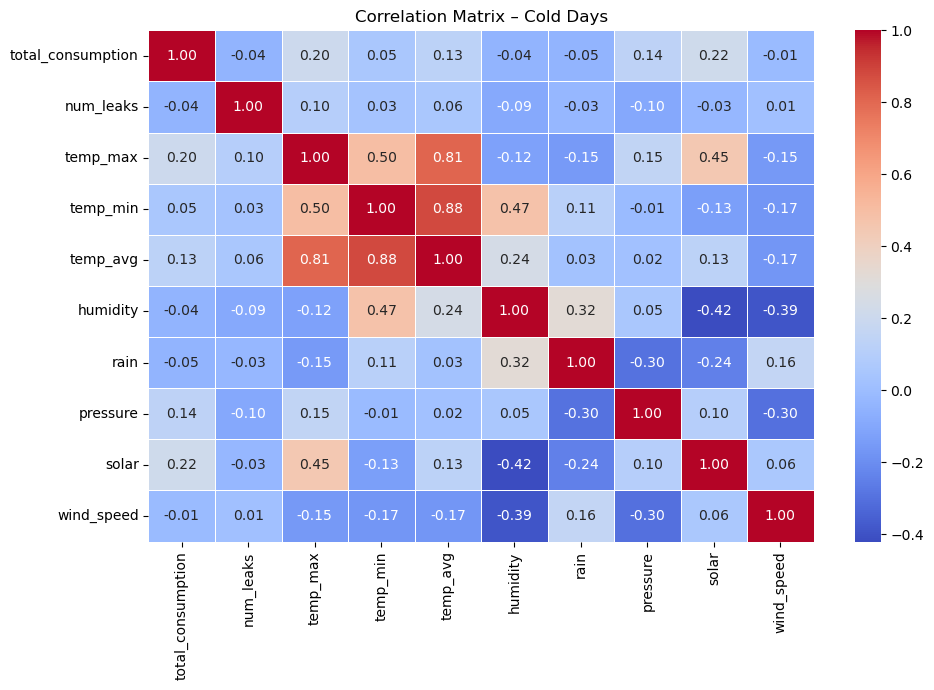


Regime: MILD  (n_days = 724)
                   total_consumption  num_leaks
total_consumption           1.000000   0.028887
num_leaks                   0.028887   1.000000
temp_max                    0.096855   0.043847
temp_min                    0.148409   0.046523
temp_avg                    0.133077   0.052453
humidity                    0.005608  -0.004651
rain                       -0.045215   0.066486
pressure                   -0.023609  -0.085862
solar                       0.046315   0.009139
wind_speed                 -0.010942   0.017532


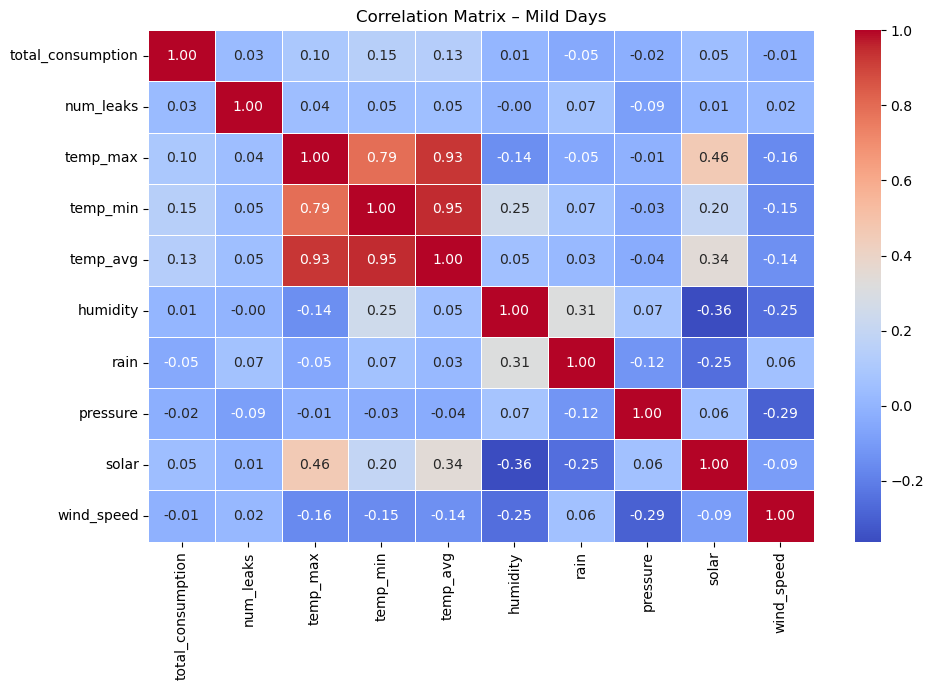


Regime: HOT  (n_days = 366)
                   total_consumption  num_leaks
total_consumption           1.000000  -0.028310
num_leaks                  -0.028310   1.000000
temp_max                   -0.017258  -0.022119
temp_min                   -0.012444   0.032392
temp_avg                    0.004477   0.009913
humidity                   -0.085914   0.090556
rain                       -0.043717   0.015471
pressure                    0.078050  -0.038109
solar                       0.113195   0.020345
wind_speed                  0.006867   0.031211


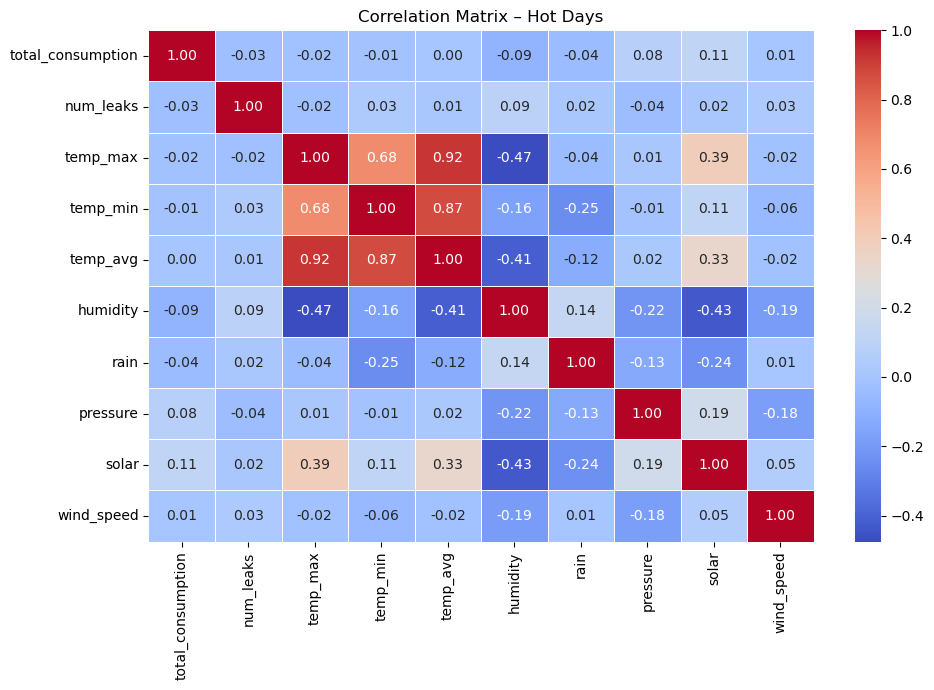


Weekdays: n_days = 1042
                   total_consumption  num_leaks
total_consumption           1.000000   0.007426
num_leaks                   0.007426   1.000000
temp_max                    0.123389   0.073336
temp_min                    0.137240   0.064854
temp_avg                    0.133392   0.071085
humidity                   -0.029328  -0.019299
rain                       -0.027520  -0.000441
pressure                   -0.008139  -0.073025
solar                       0.131275   0.061925
wind_speed                 -0.009826   0.011133


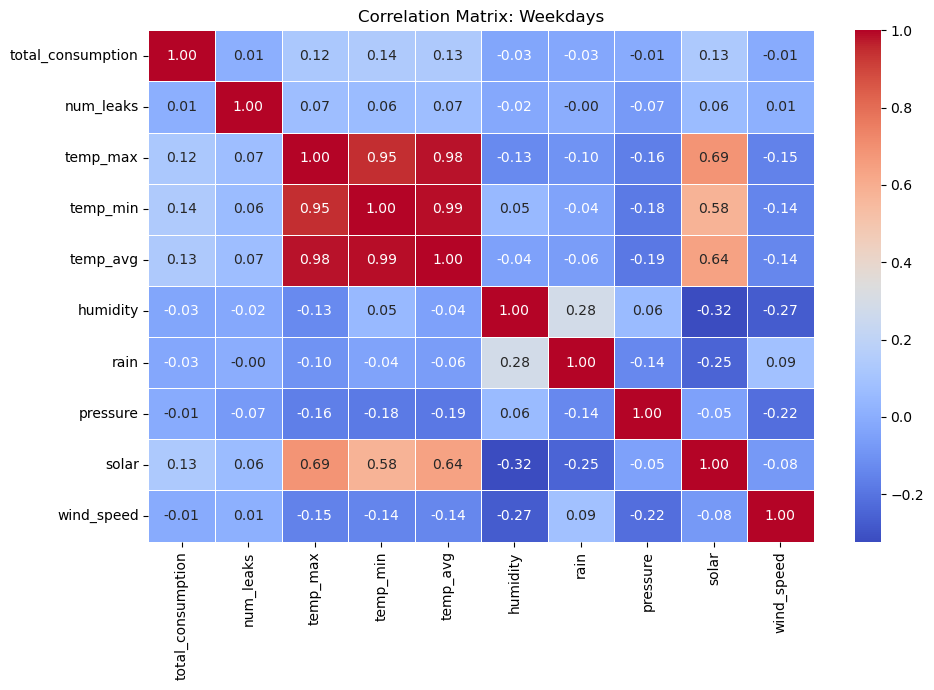


Weekends: n_days = 416
                   total_consumption  num_leaks
total_consumption           1.000000  -0.009789
num_leaks                  -0.009789   1.000000
temp_max                    0.107234   0.056086
temp_min                    0.069342   0.075122
temp_avg                    0.090964   0.063534
humidity                   -0.060182   0.046192
rain                       -0.104454   0.116270
pressure                    0.048497  -0.139709
solar                       0.122878  -0.032560
wind_speed                 -0.075278   0.006544


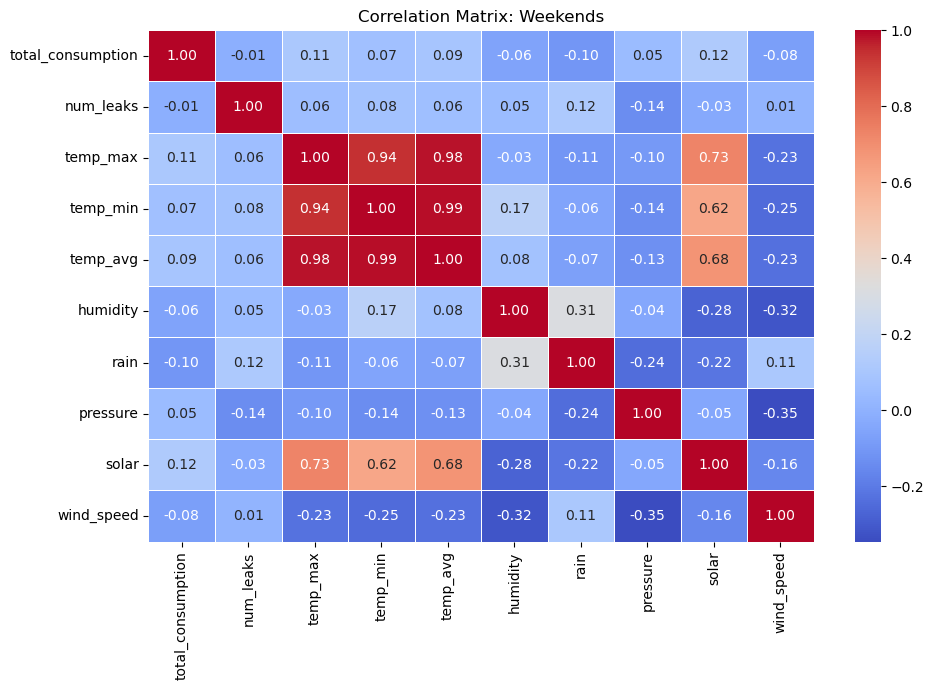

In [11]:
# ============================================================
# A. STRATIFIED CORRELATIONS: HOT vs COLD DAYS
# ============================================================

df_corr_tc = df_corr.copy()
df_corr_tc['date'] = pd.to_datetime(df_corr_tc['date'], errors='coerce')

corr_vars = [
    'total_consumption',
    'num_leaks',
    'temp_max', 'temp_min', 'temp_avg',
    'humidity', 'rain', 'pressure',
    'solar', 'wind_speed'
]

# keep only rows with all variables present
df_corr_tc = df_corr_tc.dropna(subset=corr_vars)

# --- 1. Define hot / cold / mild based on temp_avg quartiles ----
q25 = df_corr_tc['temp_avg'].quantile(0.25)
q75 = df_corr_tc['temp_avg'].quantile(0.75)

def temp_regime(t):
    if t <= q25:
        return 'cold'
    elif t >= q75:
        return 'hot'
    else:
        return 'mild'

df_corr_tc['temp_regime'] = df_corr_tc['temp_avg'].apply(temp_regime)

print("Rows available for temperature-regime correlation:", len(df_corr_tc))
print(f"Thresholds: cold ≤ {q25:.2f} °C, hot ≥ {q75:.2f} °C")

# --- 2. Correlation matrices for cold / mild / hot ----------------
for regime in ['cold', 'mild', 'hot']:
    sub = df_corr_tc[df_corr_tc['temp_regime'] == regime]
    if len(sub) < 30:
        print(f"\nSkipping {regime} (only {len(sub)} days)")
        continue

    print(f"\nRegime: {regime.upper()}  (n_days = {len(sub)})")
    corr_mat = sub[corr_vars].corr()
    # quick text view for the most important relations
    print(corr_mat[['total_consumption', 'num_leaks']])

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        corr_mat,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=0.5
    )
    plt.title(f"Correlation Matrix – {regime.capitalize()} Days")
    plt.tight_layout()
    plt.show()


# --- 3. OPTIONAL: WEEKDAY vs WEEKEND COMPARISON -----------------------------
for flag, label in [(False, 'Weekdays'), (True, 'Weekends')]:
    sub = df_corr_tc[df_corr_tc['is_weekend'] == flag]
    if len(sub) < 30:
        print(f"\nSkipping {label} (only {len(sub)} days)")
        continue

    print(f"\n{label}: n_days = {len(sub)}")
    corr_mat = sub[corr_vars].corr()
    print(corr_mat[['total_consumption', 'num_leaks']])

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        corr_mat,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=0.5
    )
    plt.title(f"Correlation Matrix: {label}")
    plt.tight_layout()
    plt.show()


This block gives you visual intuition:
- Consumption vs temperature (with LOWESS curve).
- Consumption vs solar radiation.
- Leaks vs rain (binned).
- Leaks on dry vs very rainy and cold vs hot days.

By looking at the scatter plots and box plots we can state that: 
- scatter + LOWESS (LOWESS curve reveals the underlying trend by fitting a small logistic regression to each x-value) visually confirm the small but consistent positive link between **consumption** and **“good weather”**.
- heavy rain may be associated with some extreme-leak days, but overall the effect is weak and noisy.
- temperature category doesn’t clearly separate “high-leak” vs “low-leak” days at city scale.

Hence, we can say that no strong, clean signal linking daily leaks to simple weather thresholds.

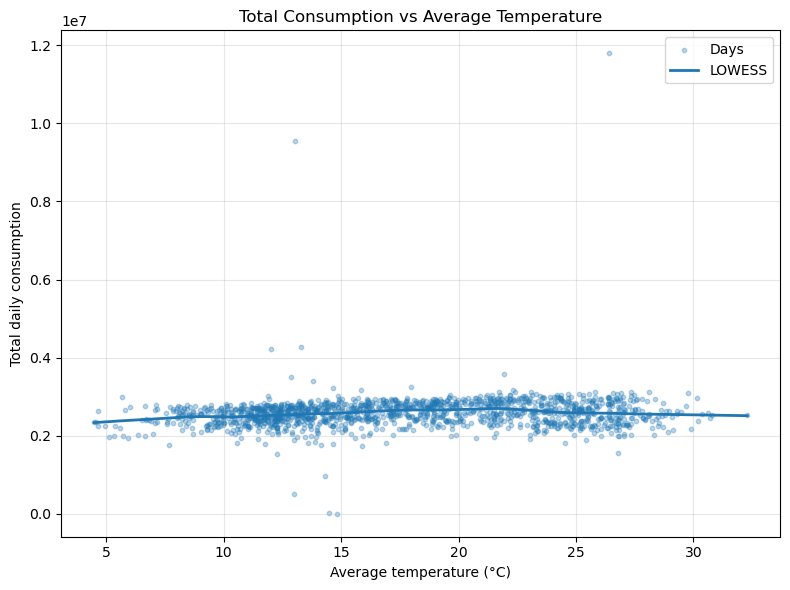

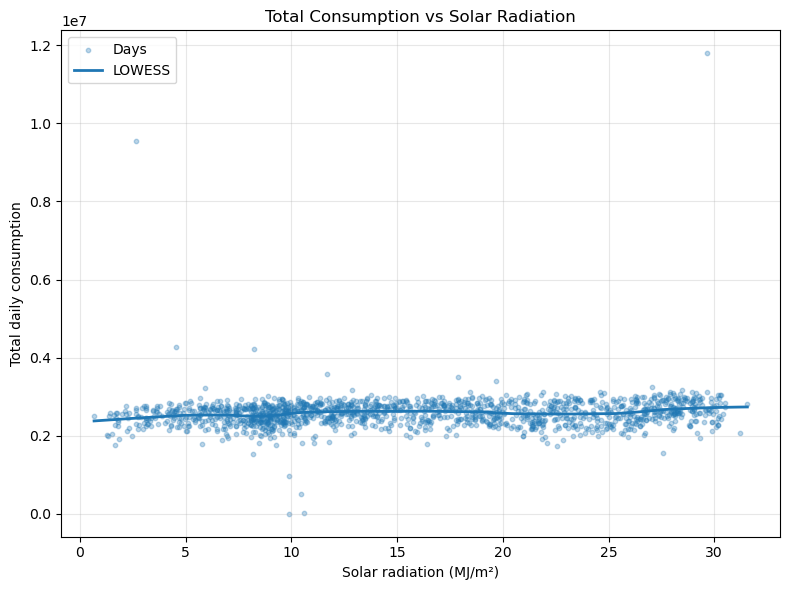

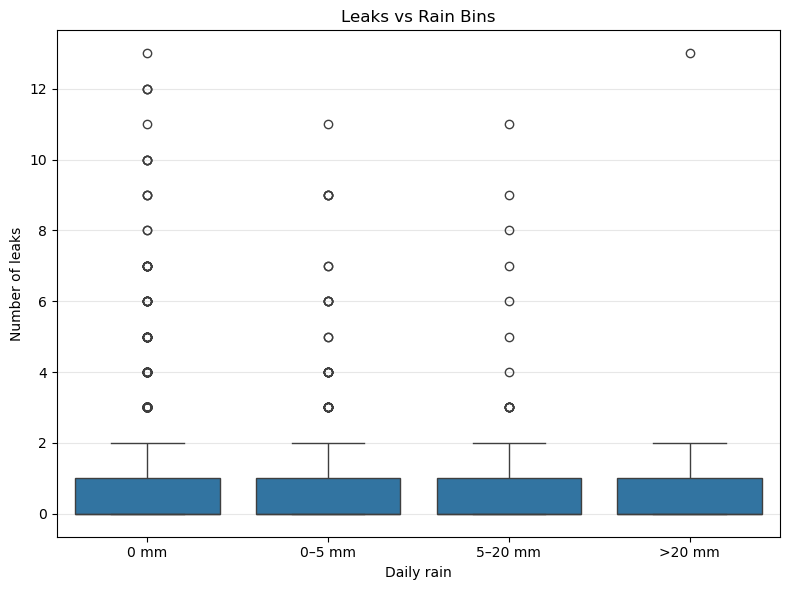

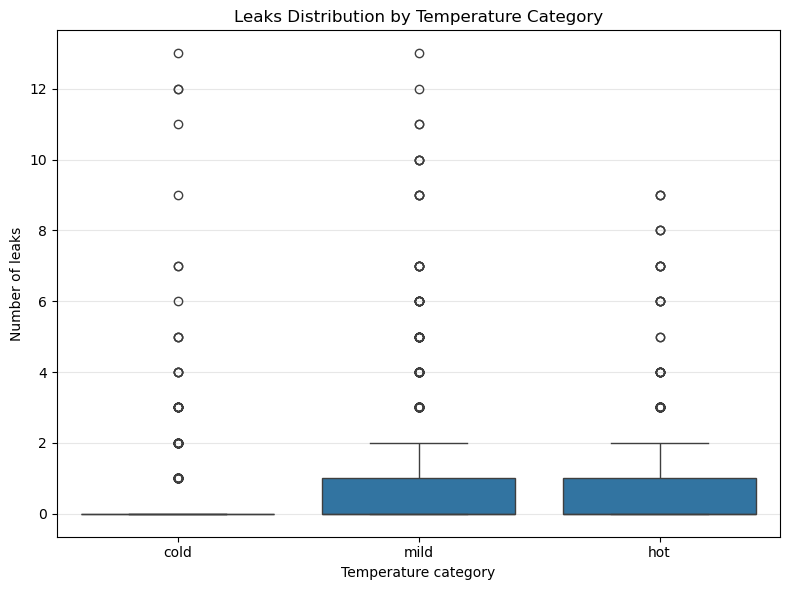

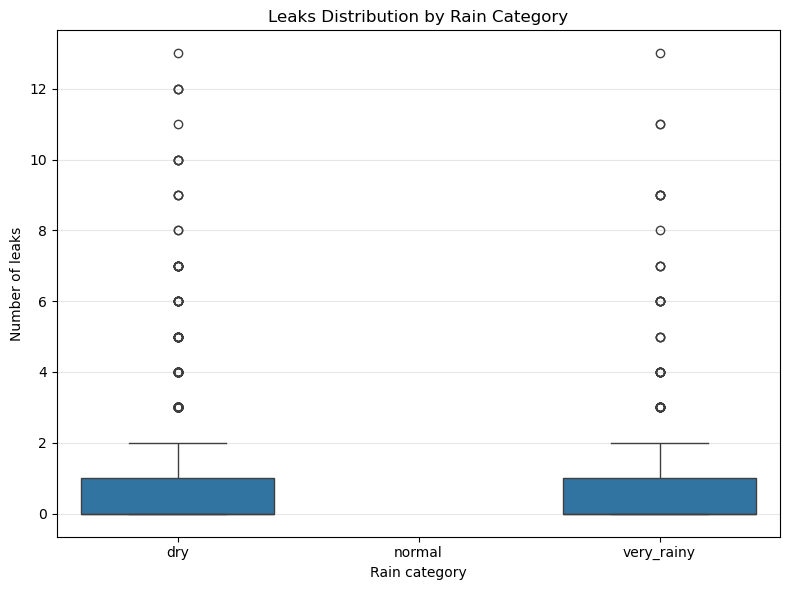

In [14]:
# ============================================================
# C. DISTRIBUTIONS & SCATTER PLOTS
# ============================================================

from statsmodels.nonparametric.smoothers_lowess import lowess

df_plot = df_corr.copy()
df_plot = df_plot.dropna(subset=['total_consumption', 'temp_avg', 'solar', 'rain', 'num_leaks'])

# ---------- 1. Consumption vs temperature (scatter + LOWESS) ----------
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['temp_avg'], df_plot['total_consumption'],
            alpha=0.3, s=10, label='Days')

# LOWESS smooth curve
lowess_curve = lowess(df_plot['total_consumption'],
                      df_plot['temp_avg'],
                      frac=0.2)
plt.plot(lowess_curve[:, 0], lowess_curve[:, 1],
         linewidth=2, label='LOWESS')

plt.xlabel("Average temperature (°C)")
plt.ylabel("Total daily consumption")
plt.title("Total Consumption vs Average Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 2. Consumption vs solar radiation ----------
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['solar'], df_plot['total_consumption'],
            alpha=0.3, s=10, label='Days')
lowess_curve = lowess(df_plot['total_consumption'],
                      df_plot['solar'],
                      frac=0.2)
plt.plot(lowess_curve[:, 0], lowess_curve[:, 1],
         linewidth=2, label='LOWESS')

plt.xlabel("Solar radiation (MJ/m²)")
plt.ylabel("Total daily consumption")
plt.title("Total Consumption vs Solar Radiation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 3. Leaks vs rain (binned) ----------
# Create rain bins
bins = [-0.001, 0, 5, 20, np.inf]
labels = ['0 mm', '0–5 mm', '5–20 mm', '>20 mm']
df_plot['rain_bin'] = pd.cut(df_plot['rain'], bins=bins, labels=labels)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x='rain_bin', y='num_leaks')
plt.xlabel("Daily rain")
plt.ylabel("Number of leaks")
plt.title("Leaks vs Rain Bins")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 4. Leaks on extreme vs normal days ----------
# Define hot / cold / dry / rainy flags
temp_q25 = df_plot['temp_avg'].quantile(0.25)
temp_q75 = df_plot['temp_avg'].quantile(0.75)
rain_q75 = df_plot['rain'].quantile(0.75)

df_plot['temp_category'] = np.where(
    df_plot['temp_avg'] >= temp_q75, 'hot',
    np.where(df_plot['temp_avg'] <= temp_q25, 'cold', 'mild')
)

df_plot['rain_category'] = np.where(
    df_plot['rain'] >= rain_q75, 'very_rainy',
    np.where(df_plot['rain'] == 0, 'dry', 'normal')
)

# Boxplot: leaks by temperature category
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x='temp_category', y='num_leaks',
            order=['cold', 'mild', 'hot'])
plt.xlabel("Temperature category")
plt.ylabel("Number of leaks")
plt.title("Leaks Distribution by Temperature Category")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot: leaks by rain category
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x='rain_category', y='num_leaks',
            order=['dry', 'normal', 'very_rainy'])
plt.xlabel("Rain category")
plt.ylabel("Number of leaks")
plt.title("Leaks Distribution by Rain Category")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


- **Leak metrics are highly redundant**
  - `total_leaks` and `leaks_per_year` are almost perfectly correlated (r ≈ 0.88).
  - For the vulnerability score, it is enough to keep **one** of them (e.g. `leaks_per_year`).

- **Leak density adds new information**
  - `leaks_per_1000_meters` is only moderately correlated with total leaks (r ≈ 0.45–0.48).
  - This metric captures how *leaky* a section is **relative to the size of its network**, so it contributes a distinct dimension of vulnerability.

- **Consumption strongly reflects network size**
  - `mean_daily_consumption` and `num_meters` are strongly correlated (r ≈ 0.79).
  - High total consumption is mostly driven by having many meters (larger or denser network areas).

- **Intensity vs. size**
  - `consumption_per_meter` has only a moderate correlation with `mean_daily_consumption` (r ≈ 0.40).
  - Some sections are “big” (many meters), others are “intense” (high use per meter) – both aspects are relevant for hydraulic stress.

- **Leaks vs. consumption**
  - Sections with higher `mean_daily_consumption` tend to have more leaks (r ≈ 0.23–0.30), but the relationship is not very strong.
  - When normalized (`leaks_per_1000_meters`), the correlation with consumption becomes slightly negative (r ≈ –0.15), suggesting that **high use does not always mean proportionally leakier networks**.

- **Socioeconomic index is weakly linked to technical behaviour**
  - `socio_index` shows only very small correlations (|r| ≤ ~0.15) with leaks, consumption and number of meters.
  - Socioeconomic status should therefore be treated as a **separate social vulnerability layer**, not as a proxy for technical risk.


Section-level dataset shape: (739, 11)
  SECCIO_CENSAL  total_leaks first_leak_date last_leak_date  n_years_obs  \
0   08019301001          NaN             NaT            NaT          NaN   
1   08019301002          4.0      2024-06-19     2025-03-23          2.0   
2   08019301003          NaN             NaT            NaT          NaN   
3   08019301004          3.0      2023-03-22     2024-06-25          2.0   
4   08019301005          2.0      2024-03-02     2024-10-03          1.0   

   leaks_per_year  num_meters  mean_daily_consumption  consumption_per_meter  \
0             NaN        15.0             4648.806319             309.920421   
1             2.0         1.0              370.793651             370.793651   
2             NaN        18.0            31933.958076            1774.108782   
3             1.5        21.0             6612.793269             314.894918   
4             2.0        17.0             4186.718213             246.277542   

   socio_index  leaks_p

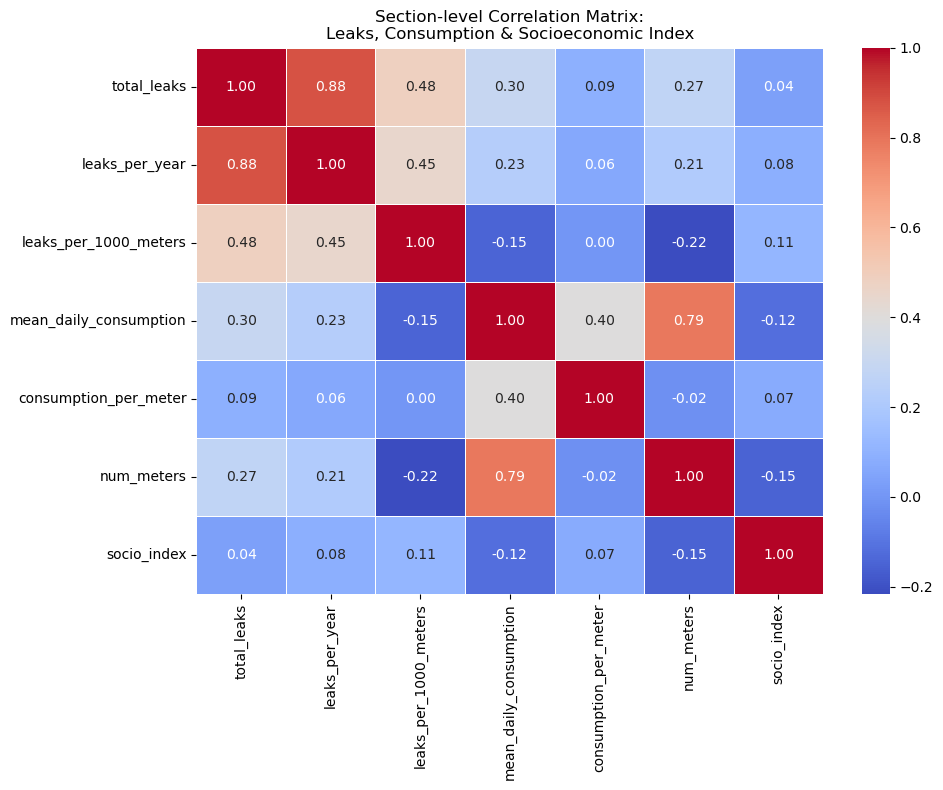

In [15]:
# ============================================================
# D. SECTION-LEVEL TRENDS (CENSUS-SECTION VULNERABILITY INPUTS)
# ============================================================

# 1) Ensure dates & years ------------------------------------
df_consum['FECHA'] = pd.to_datetime(df_consum['FECHA'], errors='coerce')
df_fuites['CREATED_MENSAJE'] = pd.to_datetime(df_fuites['CREATED_MENSAJE'], errors='coerce')

df_consum['year'] = df_consum['FECHA'].dt.year
df_fuites['year'] = df_fuites['CREATED_MENSAJE'].dt.year

# ------------------------------------------------------------
# 2) LEAK STATS PER SECCIO_CENSAL
#    - total_leaks
#    - observation_years (unique years with at least 1 leak)
#    - leaks_per_year
# ------------------------------------------------------------

leaks_per_section = (
    df_fuites
    .groupby('SECCIO_CENSAL')
    .agg(
        total_leaks=('POLISSA_SUBM', 'count'),
        first_leak_date=('CREATED_MENSAJE', 'min'),
        last_leak_date=('CREATED_MENSAJE', 'max'),
        n_years_obs=('year', 'nunique')
    )
    .reset_index()
)

# avoid division by zero
leaks_per_section['n_years_obs'] = leaks_per_section['n_years_obs'].replace(0, pd.NA)
leaks_per_section['leaks_per_year'] = (
    leaks_per_section['total_leaks'] / leaks_per_section['n_years_obs']
)

# ------------------------------------------------------------
# 3) CONSUMPTION STATS PER SECCIO_CENSAL
#    - num_meters (unique POLIZA_SUMINISTRO)
#    - mean_daily_consumption (total per section per day, averaged over days)
#    - consumption_per_meter (optional)
# ------------------------------------------------------------

# 3.1 number of meters per section
meters_per_section = (
    df_consum
    .groupby('SECCIO_CENSAL')
    .agg(num_meters=('POLIZA_SUMINISTRO', 'nunique'))
    .reset_index()
)

# 3.2 daily total consumption per section
daily_section_consum = (
    df_consum
    .groupby(['SECCIO_CENSAL', 'FECHA'])['CONSUMO_REAL']
    .sum()
    .reset_index()
)

mean_daily_consum = (
    daily_section_consum
    .groupby('SECCIO_CENSAL')['CONSUMO_REAL']
    .mean()
    .reset_index()
    .rename(columns={'CONSUMO_REAL': 'mean_daily_consumption'})
)

# Merge consumption stats
consum_section_stats = (
    meters_per_section
    .merge(mean_daily_consum, on='SECCIO_CENSAL', how='left')
)

# consumption per meter (average daily)
consum_section_stats['consumption_per_meter'] = (
    consum_section_stats['mean_daily_consumption'] /
    consum_section_stats['num_meters'].replace(0, pd.NA)
)

# ------------------------------------------------------------
# 4) SOCIOECONOMIC INDEX PER SECCIO_CENSAL
#    (df_socio_clean already filtered to Barcelona)
# ------------------------------------------------------------

# If df_socio contains multiple concepts, keep the main index only
if 'concepte' in df_socio.columns:
    socio_index = df_socio[df_socio['concepte'] == 'Índex socioeconòmic territorial'].copy()
else:
    socio_index = df_socio.copy()

socio_index = socio_index.rename(columns={'valor': 'socio_index'})
socio_index = socio_index[['SECCIO_CENSAL', 'socio_index']].drop_duplicates()

# ------------------------------------------------------------
# 5) COMBINE ALL SECTION-LEVEL FEATURES
# ------------------------------------------------------------

section_level = (
    leaks_per_section
    .merge(consum_section_stats, on='SECCIO_CENSAL', how='outer')
    .merge(socio_index, on='SECCIO_CENSAL', how='left')
)

# Leaks per 1000 meters (meters = water meters / connections)
section_level['leaks_per_1000_meters'] = (
    section_level['total_leaks'] /
    (section_level['num_meters'].replace(0, pd.NA) / 1000)
)

print("Section-level dataset shape:", section_level.shape)
print(section_level.head())

# ------------------------------------------------------------
# 6) CORRELATION MATRIX AT SECTION SCALE
# ------------------------------------------------------------

corr_vars_section = [
    'total_leaks',
    'leaks_per_year',
    'leaks_per_1000_meters',
    'mean_daily_consumption',
    'consumption_per_meter',
    'num_meters',
    'socio_index'
]

section_corr_df = section_level[corr_vars_section].dropna(how='any')

plt.figure(figsize=(10, 8))
sns.heatmap(
    section_corr_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Section-level Correlation Matrix:\nLeaks, Consumption & Socioeconomic Index")
plt.tight_layout()
plt.show()
